In [7]:
! pip install keras_tuner

In [8]:
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import keras_tuner as kt

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
data_url='/content/drive/MyDrive/Colab Notebooks/Brain-Mri-Classification/dataset'

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

X_train, y_train = [], []
X_test, y_test = [], []

image_size = 200

for label in labels:
    trainPath = os.path.join(data_url,'Training', label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file), 0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        y_train.append(labels.index(label))

    testPath = os.path.join(data_url,'Testing', label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file), 0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        y_test.append(labels.index(label))




100%|██████████| 300/300 [00:09<00:00, 32.32it/s]


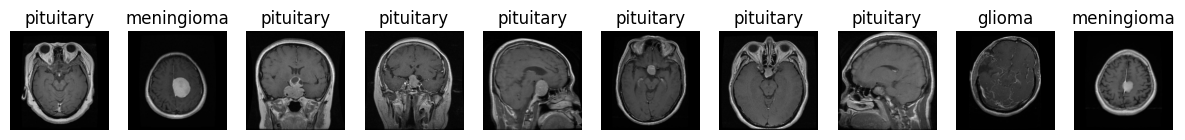

In [11]:
def visualize_data(images, labels, label_names, num_samples=10):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(label_names[labels[idx]])
        plt.axis('off')
    plt.show()

visualize_data(X_train, y_train, labels, num_samples=10)

In [12]:
X_train = np.array(X_train)[..., np.newaxis] / 255.0
X_test = np.array(X_test)[..., np.newaxis] / 255.0


print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (5738, 200, 200, 1)
Test data shape: (1321, 200, 200, 1)


In [13]:

# Convert labels to categorical (one-hot encoding)
num_classes = len(labels)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

Training labels shape: (5738, 4)
Test labels shape: (1321, 4)


In [14]:
# Split the training data into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)


Training data shape: (4590, 200, 200, 1)
Validation data shape: (1148, 200, 200, 1)
Test data shape: (1321, 200, 200, 1)


## Hyperparameter

In [16]:

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('filters_1', min_value=32, max_value=128, step=32),
                      (3, 3), activation='relu', input_shape=(image_size, image_size, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Conv2D(hp.Int('filters_2', min_value=64, max_value=128, step=32),
                      (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Conv2D(hp.Int('filters_3', min_value=128, max_value=256, step=64),
                      (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(len(labels), activation='softmax'))

    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Initialize Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='my_dir',
    project_name='intro_to_kt',
    overwrite=True
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [18]:
# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)

Trial 5 Complete [00h 13m 58s]
val_accuracy: 0.9412020742893219

Best val_accuracy So Far: 0.9412020742893219
Total elapsed time: 00h 54m 26s


In [19]:
# Get the best model

best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
# Evaluate the best model on validation set

val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9491 - loss: 0.3507
Validation Accuracy: 0.9460


In [22]:
# Train the best model again to get the history
history = best_model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping])

# Evaluate the best model on test data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - accuracy: 0.9703 - loss: 0.0879 - val_accuracy: 0.9303 - val_loss: 0.3836
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.9751 - loss: 0.0843 - val_accuracy: 0.9451 - val_loss: 0.2722
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9781 - loss: 0.0594 - val_accuracy: 0.9451 - val_loss: 0.4313
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.9786 - loss: 0.0584 - val_accuracy: 0.9399 - val_loss: 0.4524
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9722 - loss: 0.0727 - val_accuracy: 0.9329 - val_loss: 0.4663
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9142 - loss: 0.3144
Test Accuracy: 0.9440


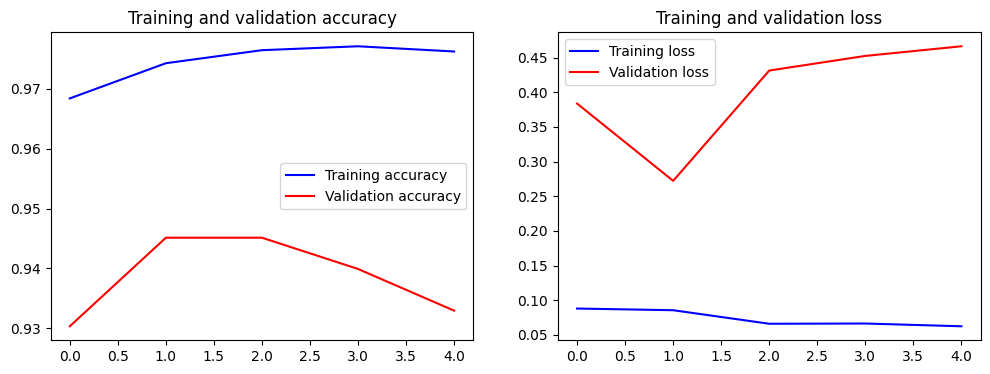

In [23]:
# Plot training and validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Call the function to plot the training history
plot_training_history(history)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.94      0.91      0.93       300
  meningioma       0.88      0.89      0.89       316
     notumor       0.97      0.99      0.98       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.94      1321
   macro avg       0.94      0.94      0.94      1321
weighted avg       0.94      0.94      0.94      1321



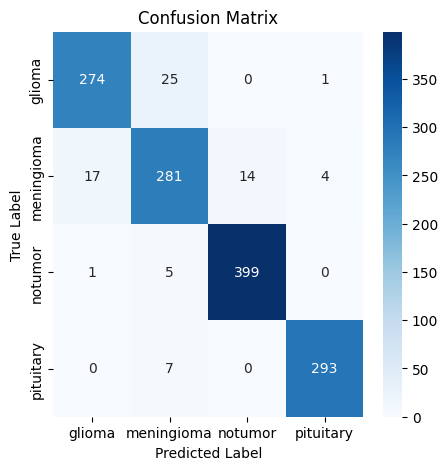

In [31]:
# Convert one-hot encoded labels to class indices for test set
y_test_classes = np.argmax(y_test, axis=1)

# Predict on the test set
y_pred_probs = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Generate classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=labels)
print("Classification Report:\n", report)


cm = confusion_matrix(y_test_classes, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


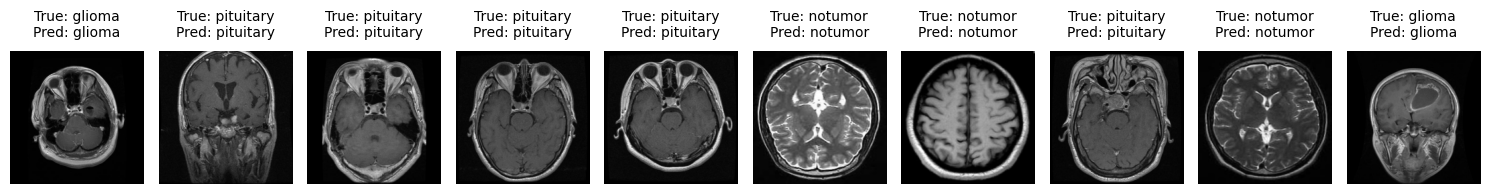

In [32]:
def visualize_test_predictions(images, labels, label_names, model, num_samples=10):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        img = images[idx]

        # Convert one-hot encoded labels to integer indices
        true_label = np.argmax(labels[idx])

        # Predict the label
        pred_label = np.argmax(model.predict(img[np.newaxis, ...])[0])

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')

        # Format the title with two lines
        plt.title(f"True: {label_names[true_label]}\nPred: {label_names[pred_label]}", fontsize=10, pad=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to visualize test predictions
visualize_test_predictions(X_test, y_test, labels, best_model, num_samples=10)


In [34]:
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Brain-Mri-Classification/hyperparameter_model.h5'
best_model.save(model_save_path)


print("HyperparameterTuning model saved as hyperparameter_model.h5")

HyperparameterTuning model saved as hyperparameter_model.h5
